In [31]:
import os
import sys
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, WeightedRandomSampler, DataLoader
from torch.optim import lr_scheduler
import random 
from PIL import Image
from matplotlib import pyplot as plt
import time
import copy
from IPython.display import clear_output
import pickle
plt.rcParams['figure.figsize'] = [10, 10]
import shutil
import glob
import datetime


In [32]:
def create_folder(folder):
    if not os.path.exists(folder):
        #os.makedirs(folder)
        os.makedirs(os.path.dirname(folder))
        
def save_to_file(data,name):    
    x = datetime.datetime.now()
    fname='model/accuracy/{}_{}_{}_{}_{}'.format(x.strftime("%Y"),x.strftime("%m"),x.strftime("%d"),x.strftime("%X"),name).replace(':', '_')
    create_folder(os.path.dirname(fname))
    pickle.dump(data, open(fname, 'wb'))
    #with open(fname, 'wb') as f:
    #    pickle.dump(data, f)
        
def load_file(fname):
    with open(fname, 'rb') as f:
        return pickle.load( f)      
    
def split_data (datapath):
    patch_list = glob.glob(datapath)
    index_map = list(range(len(patch_list)))
    random.shuffle(index_map)
    split_frac = 0.8
    split_idx = int(len(index_map)*split_frac)
    train_list, remaining_list = index_map[:split_idx], index_map[split_idx:]
    
    remaining_idx = int(len(remaining_list)*0.5)
    val_list, test_list = index_map[:remaining_idx], index_map[remaining_idx:]
    
    train_list = [patch_list[index] for index in train_list]
    val_list = [patch_list[index] for index in val_list]
    test_list = [patch_list[index] for index in test_list]
    return(train_list,val_list, test_list)

In [33]:
class northwell_loader(Dataset):
    def __init__(self, data_root='patches_50', train='train', size = 128):
        self.data_root = data_root
        self.train=train
        self.size = size
        self.label_dict = {0:'ganglia', 1:'non-ganglia'}
        self.label_dict_inv = {self.label_dict[key]:key for key in self.label_dict}
        self.classes = [folder for folder in os.listdir(os.path.join(self.data_root, 'train'))]
        
        """
        self.classes = [folder for folder in os.listdir(os.path.join(self.data_root))]       
        
        train_list_g,val_list_g, test_list_g=split_data(os.path.join(self.data_root+"/ganglia",'*.png'))
        train_list_ng, val_list_ng, test_list_ng=split_data(os.path.join(self.data_root+"/non-ganglia", '*.png'))
        
        train_list = train_list_g + train_list_ng
        val_list = val_list_g + val_list_ng
        test_list = test_list_g + test_list_ng

        random.shuffle(train_list)
        random.shuffle(val_list)
        random.shuffle(test_list)
        
        
        self.all_data = {'train': train_list, 
                         'val': val_list,
                         'test': test_list}
        """
        
        self.all_data = {'train':[os.path.join(self.data_root, 'train', folder, file) for folder in os.listdir(os.path.join(self.data_root, 'train')) 
                                  for file in os.listdir(os.path.join(self.data_root, 'train', folder)) if '.png' in file], 
                         'val':[os.path.join(self.data_root, 'val', folder, file) for folder in os.listdir(os.path.join(self.data_root, 'val')) 
                                  for file in os.listdir(os.path.join(self.data_root, 'val', folder)) if '.png' in file],
                         'test':[os.path.join(self.data_root, 'test', folder, file) for folder in os.listdir(os.path.join(self.data_root, 'test')) 
                                  for file in os.listdir(os.path.join(self.data_root, 'test', folder)) if '.png' in file]}
         
        
        self.weight_counts = [self.label_dict_inv[os.path.basename(os.path.dirname(file))] for file in self.all_data['train']]
        self.weight_counts = [self.weight_counts.count(num) for num in self.label_dict]
        self.weight_per_class = {count:sum(self.weight_counts)/item for count, item in enumerate(self.weight_counts)}
        self.weights = [self.weight_per_class[self.label_dict_inv[os.path.basename(os.path.dirname(file))]] for file in self.all_data['train']] 
    
    def __len__(self):
        return(len(self.all_data[self.train]))
    
    
    def __getitem__(self, idx):
        path = self.all_data[self.train][idx]
        img = Image.open(path)
        label = self.label_dict_inv[os.path.basename(os.path.dirname(path))]
        
        if self.train == 'train':
            transform = transforms.Compose([
                transforms.Resize((self.size, self.size)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.GaussianBlur((15,15)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]),
            ])
            
        elif self.train in ['val', 'test']:
            transform = transforms.Compose([
                transforms.Resize((self.size, self.size)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]),
            ])
            
        img = transform(img)
        return(img, label)

In [34]:
def train_model(model, criterion, optimizer, scheduler,model_name='resnet50',patches='patches_50', num_epochs=16,rate=0.45):
    since = time.time()
    
    training_dataset = northwell_loader(data_root=patches, train='train', size = 128)
    val_dataset = northwell_loader(data_root=patches, train='val', size = 128)
    weights = torch.DoubleTensor(training_dataset.weights)
    sampler = WeightedRandomSampler(weights, len(weights))
    
    
    train_loader = DataLoader(training_dataset, batch_size=batch_size, sampler = sampler)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    #device = torch.device('cuda:{}'.format(gpu))
    train_on_gpu = torch.cuda.is_available()
    
    best_model_saved = 0
    saveroot = 'model/{}/{}'.format(model_name,time.ctime()).replace(':', '-').replace(' ', '_')
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    epochs = []
    train_accs = []
    val_accs = []
    
    
    for epoch in range(num_epochs):
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                #inputs = inputs.to(device)
                #labels = labels.to(device)
                if train_on_gpu:
                    inputs, labels = inputs.cuda(), labels.cuda()                

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(training_dataset.all_data[phase])
            epoch_acc = running_corrects.double() / len(training_dataset.all_data[phase])
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'train':
                train_accs.append(float(epoch_acc.detach().cpu().numpy()))
                print('Epoch: {}; Training loss: {}'.format(epoch, epoch_loss))
            else:
                epochs.append(str(epoch))
                val_accs.append(float(epoch_acc.detach().cpu().numpy()))
                #clear_output()
                print('Epoch {}/{}'.format(epoch, num_epochs - 1))
                print('Epoch: {}; Val loss: {}'.format(epoch, epoch_loss))
                print('-' * 10)
                #plt.plot(epochs, train_accs)
                #plt.plot(epochs, val_accs)
                #plt.show()            

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                savepath = os.path.join(saveroot, '{}.pkl'.format(best_model_saved))
                if not os.path.exists(os.path.dirname(savepath)):
                    os.makedirs(os.path.dirname(savepath))
                pickle.dump(best_model_wts, open(savepath, 'wb'))
                best_model_saved += 1
                print('NEW BEST SAVED')

        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    accfname=f'{model_name}_{patches}_{rate}'
    save_to_file(epochs,f'{accfname}_epochs')
    save_to_file(train_accs,f'{accfname}_train_accs')
    save_to_file(val_accs,f'{accfname}_val_accs')      
    return (model,epochs, train_accs,val_accs)

In [36]:

def append_dropout(model, rate=0.3):
        for name, module in model.named_children():
            if len(list(module.children())) > 0:
                append_dropout(module)
            if isinstance(module, nn.ReLU):
                new = nn.Sequential(module, nn.Dropout2d(p=rate, inplace=True))
                setattr(model, name, new)

def start_train(batch_size, model_name='resnet50',patches='patches_50',num_epochs=30, rate=0.3):
    device = torch.device('cuda:{}'.format(gpu))
    train_on_gpu = torch.cuda.is_available()
    
    #########################
    if (model_name=='resnet50'):
        model_ft = models.resnet50(pretrained=True)
    elif (model_name=='resnet152'):
        model_ft = models.resnet152(pretrained=True)
    elif (model_name == 'resnet34'):
        model_ft = models.resnet34(pretrained=True)
    elif (model_name == 'resnet18'):
        model_ft = models.resnet18(pretrained=True)
    else:
        model_ft = models.resnet50(pretrained=True)       

    #append_dropout(model_ft,rate = rate)
    training_dataset = northwell_loader(data_root=patches, train='train', size = 128)
   
    num_ftrs = model_ft.fc.in_features
    #model_ft.fc = nn.Linear(num_ftrs, len(training_dataset.label_dict))
    if (rate>0):
        model_ft.fc = nn.Sequential(nn.Dropout(rate), nn.Linear(num_ftrs,  len(training_dataset.label_dict)))
    else:
        model_ft.fc = nn.Linear(num_ftrs, len(training_dataset.label_dict))   
        
    #model_ft = model_ft.to(device)
    
    # if GPU is available, move the model to GPU
    if train_on_gpu:
        model_ft.cuda()

    criterion = nn.CrossEntropyLoss()
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)
    model_ft,epochs, train_accs,val_accs = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,model_name,patches, num_epochs=num_epochs, rate=rate)

In [ ]:
batch_size = 128
gpu = '1'
#num_epochs = 30
start_train(batch_size=batch_size, model_name='resnet152', patches='patches_norm',num_epochs=30,rate=0)


train Loss: 0.4585 Acc: 0.7721
Epoch: 0; Training loss: 0.4584756243765213
val Loss: 0.5152 Acc: 0.7421
Epoch 0/29
Epoch: 0; Val loss: 0.5152374783624059
----------
NEW BEST SAVED

train Loss: 0.4150 Acc: 0.8002
Epoch: 1; Training loss: 0.4150130747102242
val Loss: 0.5372 Acc: 0.7472
Epoch 1/29
Epoch: 1; Val loss: 0.5372154426526
----------
NEW BEST SAVED

train Loss: 0.3992 Acc: 0.8078
Epoch: 2; Training loss: 0.39923851649499636
val Loss: 0.5810 Acc: 0.7538
Epoch 2/29
Epoch: 2; Val loss: 0.5809813683683221
----------
NEW BEST SAVED

train Loss: 0.3842 Acc: 0.8201
Epoch: 3; Training loss: 0.38422012235013725
val Loss: 0.5374 Acc: 0.7273
Epoch 3/29
Epoch: 3; Val loss: 0.5373770292007399
----------

train Loss: 0.3740 Acc: 0.8239
Epoch: 4; Training loss: 0.37400458154475114
val Loss: 0.5673 Acc: 0.7426
Epoch 4/29
Epoch: 4; Val loss: 0.5673204828453259
----------

train Loss: 0.3633 Acc: 0.8254
Epoch: 5; Training loss: 0.3633461625160151
val Loss: 0.5379 Acc: 0.7426
Epoch 5/29
Epoch: 5; 

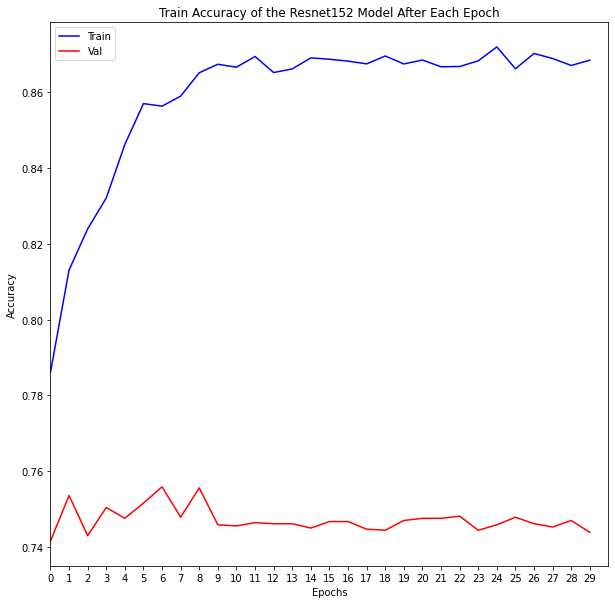

In [18]:
fname='2022_08_08_12_52_57' #no rate,patches_66
#fname='2022_08_08_21_58_21' #no rate,patches_50
#fname='2022_08_19_07_42_22' #rate=0.45,patches_50
fname='2022_08_19_16_30_33_resnet152_patches_66_0'

epochsno=load_file(f'model/accuracy/{fname}_epochs')
train_accs=load_file(f'model/accuracy/{fname}_train_accs')
val_accs=load_file(f'model/accuracy/{fname}_val_accs')

plt.title("Train Accuracy of the Resnet152 Model After Each Epoch")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(epochsno, train_accs, "-b", label="Train")
plt.plot(epochsno, val_accs, "-r", label="Val")
plt.legend(loc="upper left")
#plt.ylim(0, 1.0)
plt.xlim(0, 30)
plt.show()

In [ ]:
test_loss=0.0
class_corect = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model_ft = pickle.load(load_pickle_file)
model_ft.eval()
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
for data, target in test_loader:
    data, target = data.cuda(), target.cuda()
    out = resnet50(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = touch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
test_loss = test_loss/len(test_loader.dataset)
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))